In [84]:
import numpy as np 
import datetime as dt 
import pandas as pd 
from pandas_datareader import data as pdr 
import yfinance as yfin 
import cvxpy as cp
import requests
import matplotlib.pyplot as plt
#import plotly.pyplot as plt
yfin.pdr_override()

# Data Gathering

In [127]:
def tickers_sp500():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    df = pd.read_html(url, header=0)[0]
    tickers = df['Symbol'].tolist()
    return tickers

In [217]:
print(len(tickers_sp500()))

503


In [218]:
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks,start=start,end=end)
    stockData = stockData['Close']
    stockData = stockData.dropna(axis=1, how='any')
    updated_stockList = stockData.columns.tolist() 

    returns = stockData.pct_change().dropna() 
    meanReturns = returns.mean() 
    covMatrix = returns.cov()

    return updated_stockList, returns, meanReturns, covMatrix 
def sanitize_tickers(tickers):
    sanitized_tickers = []
    for ticker in tickers:
        if '.' in ticker:
            ticker = ticker.replace('.', '-')
        sanitized_tickers.append(ticker)
    return sanitized_tickers

### GET DATA ###
heldout_days = 30
stockList = sanitize_tickers(tickers_sp500())

endDate = dt.datetime.now() - dt.timedelta(days=heldout_days)
startDate = endDate - dt.timedelta(days=365)

stockList, back_returns, back_meanReturns, back_covMatrix = getData(stockList,startDate,endDate)
returns, meanReturns, covMatrix = back_returns, back_meanReturns, back_covMatrix

print(meanReturns, covMatrix)

[*********************100%%**********************]  503 of 503 completed


Ticker
A       0.000823
AAL     0.000273
AAPL    0.000506
ABBV    0.000520
ABNB    0.001407
          ...   
XYL     0.001401
YUM     0.000276
ZBH    -0.000264
ZBRA    0.001070
ZTS     0.000132
Length: 500, dtype: float64 Ticker         A       AAL      AAPL      ABBV      ABNB       ABT  \
Ticker                                                               
A       0.000273  0.000070  0.000021  0.000028  0.000072  0.000066   
AAL     0.000070  0.000531  0.000074  0.000021  0.000191  0.000007   
AAPL    0.000021  0.000074  0.000162 -0.000001  0.000073  0.000007   
ABBV    0.000028  0.000021 -0.000001  0.000138  0.000027  0.000032   
ABNB    0.000072  0.000191  0.000073  0.000027  0.000466  0.000047   
...          ...       ...       ...       ...       ...       ...   
XYL     0.000089  0.000092  0.000046  0.000022  0.000074  0.000051   
YUM     0.000050  0.000037  0.000024  0.000018  0.000059  0.000045   
ZBH     0.000058  0.000061  0.000036  0.000029  0.000054  0.000075   
ZBRA    

# Mean Variance Optimization

In [219]:
def minVar(meanReturns, covMatrix, annualTargetReturn):
    mu = meanReturns 
    Sigma = covMatrix 

    n = len(mu)
    w = cp.Variable(n, pos = True)
    rMin = annualTargetReturn / 252
    obj = cp.Minimize(w.T @ Sigma @ w)
    constraints = [cp.sum(w) == 1,
                   w.T @ mu >= rMin]
    for i in range(n):
        constraints += [w[i] <= 0.05] # no stock can be more than 5% of portfolio
    prob = cp.Problem(obj, constraints)
    result = prob.solve(solver="GUROBI",verbose=False)
    
    return w.value, result

def maxRet(meanReturns, covMatrix, annualTargetVariance):
    mu = meanReturns
    Sigma = covMatrix 

    n = len(mu) 
    w = cp.Variable(n,pos=True)
    sMax = annualTargetVariance / 252
    obj = cp.Maximize(w.T @ mu)
    constraints = [cp.sum(w) == 1,
                   w.T @ Sigma @ w <= sMax]
    for i in range(n):
        constraints += [w[i] <= 0.05] # no stock can be more than 5% of portfolio
    prob = cp.Problem(obj,constraints)
    result = prob.solve(solver="GUROBI",verbose=True)

    return w.value, result 

# Efficient Frontier

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jun 21 03:25:29 PM: Your problem has 500 variables, 502 constraints, and 0 parameters.
(CVXPY) Jun 21 03:25:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 21 03:25:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 21 03:25:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 21 03:25:29 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 21 03:25:29 PM: Compiling problem (target solver=GUROBI).

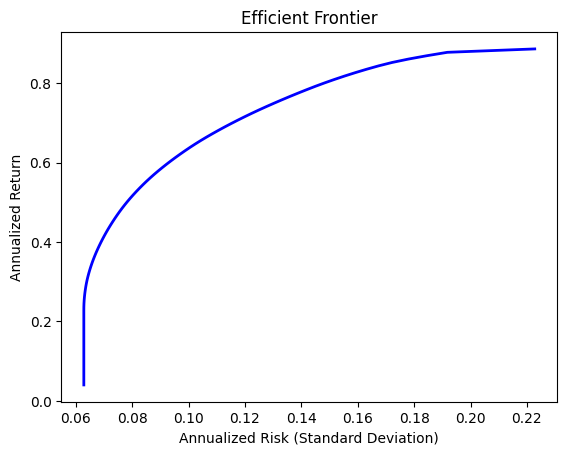

In [221]:
allocation, result = maxRet(meanReturns,covMatrix,10000)

max_return = result*252
rf = 0.04

target_returns = np.linspace(rf,max_return,100)

eff_frontier_returns = []
eff_frontier_risk = [] 

for r in target_returns: 
    w, var = minVar(meanReturns, covMatrix, r)
    eff_frontier_returns.append(r) 
    eff_frontier_risk.append(np.sqrt(var*252))

plt.plot(eff_frontier_risk, eff_frontier_returns, 'b', linewidth=2)
plt.xlabel('Annualized Risk (Standard Deviation)')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier')
plt.show()

In [222]:
print(len(allocation))
print(len(stockList))

500
500


In [223]:
allocation, result = minVar(meanReturns,covMatrix,0.6) # choose target annualized return at an elbow

stdev = (result * 252) ** 0.5
print(stdev)
roundedWeights = [np.round(x,2) for x in allocation]
d = {"Ticker": stockList, "Allocation":roundedWeights}
df = pd.DataFrame(data = d)
df.sort_values(by="Allocation",ascending=False)

0.09296910842898481


,Ticker,Allocation
488,WRK,0.05
340,NRG,0.05
199,GD,0.05
486,WMT,0.05
300,MCK,0.05
...,...,...
167,EQR,0.00
166,EQIX,0.00
165,EPAM,0.00
164,EOG,0.00


# Monte Carlo Simluation

In [224]:
def mcCVaR(returns, alpha=5):
    VaR = np.percentile(returns,alpha)
    belowVaR = returns <= VaR
    return returns[belowVaR].mean()

In [225]:
eigenvalues = np.linalg.eigvals(covMatrix)
#print(eigenvalues) # some eigen values are very small, so we must regularize the covariance matrix 

def make_positive_definite(matrix, epsilon=1e-10):
    try: 
        np.linalg.cholesky(matrix)
        return matrix
    except np.linalg.LinAlgError:
        pass 
    
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    eigenvalues = np.maximum(eigenvalues, epsilon)
    matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T 
    return matrix 

covMatrix = make_positive_definite(covMatrix)

Starting Value $100 

After 30 days:
Mean $107.47
Median $107.2
Maximum $114.68
Minimum $100.54
CVaR $101.73


<function matplotlib.pyplot.show(close=None, block=None)>

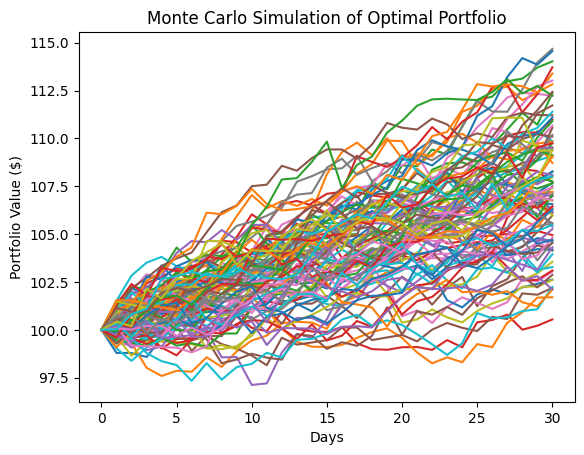

In [226]:
mc_sims = 100 
T = 30 

meanM = np.full(shape=(T,len(allocation)),fill_value=meanReturns)
meanM = meanM.T 

portfolio_sims = np.full(shape=(T+1,mc_sims),fill_value=0.0)

initialPortfolio = 100 

portfolio_sims[0,:] = initialPortfolio 

for m in range(mc_sims):
    Z = np.random.normal(size=(T,len(allocation))) 
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L,Z)
    portfolio_sims[1:,m] = np.cumprod(np.inner(allocation,dailyReturns.T)+1)*initialPortfolio

mean = np.mean(portfolio_sims[-1,:])
med = np.median(portfolio_sims[-1,:])
min = np.min(portfolio_sims[-1,:])
max = np.max(portfolio_sims[-1,:])
portResults = pd.Series(portfolio_sims[-1,:])
CVaR = mcCVaR(portResults)

print('Starting Value ${} \n'.format(initialPortfolio))
print('After {} days:'.format(T))
print('Mean ${}'.format(round(mean,2)))
print('Median ${}'.format(round(med,2)))
print('Maximum ${}'.format(round(max,2)))
print('Minimum ${}'.format(round(min,2)))
print("CVaR ${}".format(round(CVaR,2)))

plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("Monte Carlo Simulation of Optimal Portfolio")
plt.show

# Back Testing and Forward Testing

In [232]:
def test(allocation,returns,title):
    numAssets = len(allocation)
    initial_investment = 100 

    optimalPortfolio = allocation 
    optimal_returns = np.matmul(returns, optimalPortfolio)
    opt_cum = (1+optimal_returns).cumprod() * initial_investment

    uniformPortfolio = numAssets*[1./numAssets]
    uniform_returns = np.matmul(returns, uniformPortfolio) 
    uni_cum = (1+uniform_returns).cumprod() * initial_investment

    plt.figure(figsize=(10, 6))
    plt.plot(opt_cum, label='Optimal Allocation')
    plt.plot(uni_cum, label='Equal Allocation')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title(title)
    plt.legend()
    plt.show()

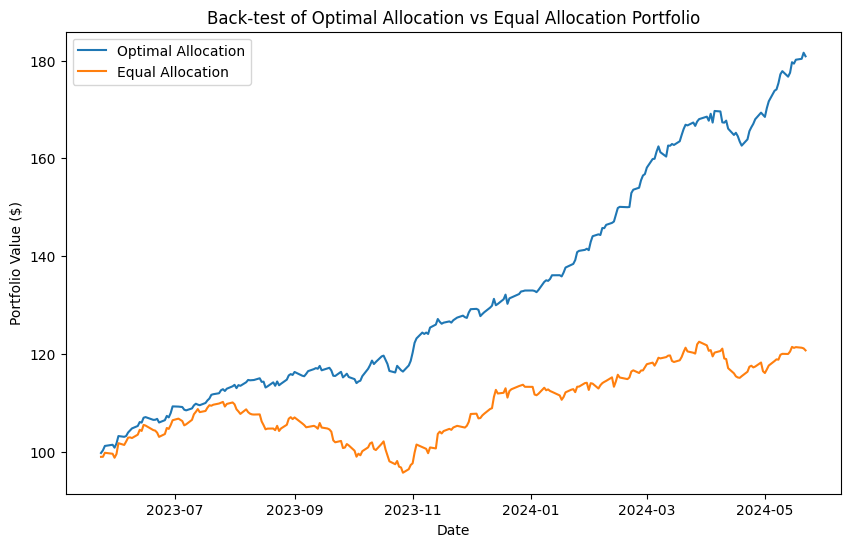

In [256]:
test(allocation,back_returns,'Back-test of Optimal Allocation vs Equal Allocation Portfolio')

In [248]:
heldout_days = 1
stockList = sanitize_tickers(tickers_sp500())

endDate = dt.datetime.now() - dt.timedelta(days=heldout_days)
startDate = endDate - dt.timedelta(days=365)

stockList, fwd_returns, fwd_meanReturns, fwd_covMatrix = getData(stockList,startDate,endDate)
recent_returns = fwd_returns.tail(30)

[*********************100%%**********************]  503 of 503 completed


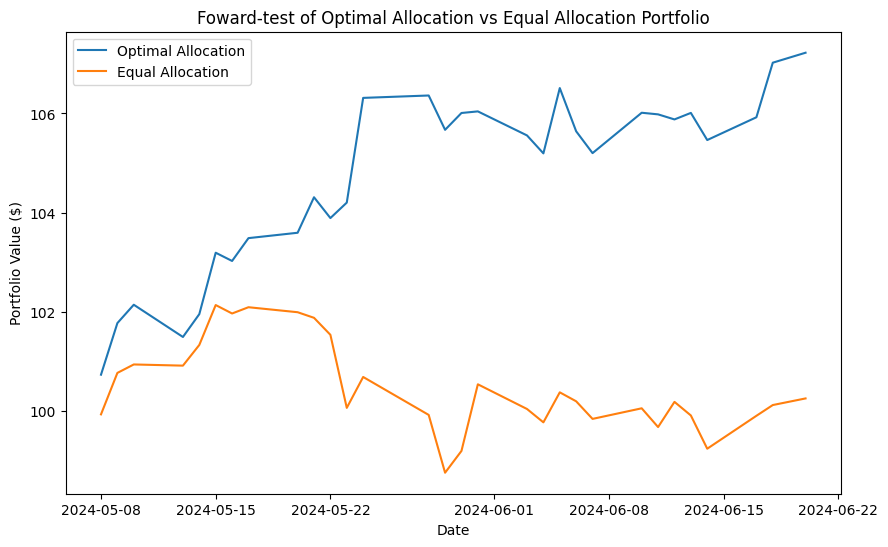

In [255]:
test(allocation,recent_returns,'Foward-test of Optimal Allocation vs Equal Allocation Portfolio')

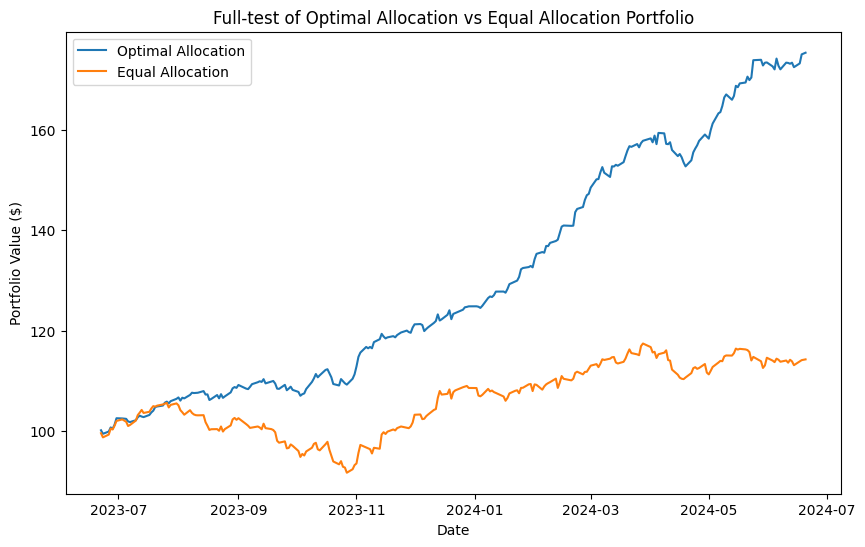

In [254]:
test(allocation,fwd_returns,'Full-test of Optimal Allocation vs Equal Allocation Portfolio')